
### Text Clustering with Sentence Transformers  ###
### and a Modified K-Means Clustering Algorithm ###


This notebook provides a simple implementation of a text clustering algorithm that uses sentence embeddings generated by the SBERT model and a modified version of the k-means clustering algorithm to group similar sentences together. The output of the algorithm is a set of clusters, each with a representative sentence, and a list of outlier sentences that could not be assigned to any cluster.

## Data

The data for this notebook is a collection of requests. Each request is a sentence, and the goal of the algorithm is to group together similar requests so that they can be handled more efficiently by support staff.

## Method

The algorithm works by first transforming the input data into SBERT embeddings, which can be thought of as numerical representations of the meaning of each sentence. The algorithm then randomly chooses one of the embeddings to serve as the first cluster center.

For each subsequent embedding, the algorithm checks whether the embedding is closer to an existing cluster center than a predetermined threshold. If it is, the embedding is assigned to that cluster. Otherwise, the embedding is added to the list of cluster centers.

The clusters are then analyzed to generate representative sentences and cluster names using a combination of topic modeling and n-gram analysis. The results are saved to a JSON file for further analysis or use in downstream applications.

## Conclusion

This notebook provides a simple but effective method for grouping similar sentences together based on their meaning, and can be easily extended or modified for use in other applications.

**Project by: Yuval Vinokur, Dvir Magen**


# Getting Started

Before we begin, let's first download the necessary datasets. If you prefer to use your own dataset, feel free to upload it to the Colab runtime.

Please make sure to run the code cell below to download the required evaluations and datasets.


In [ ]:
!wget https://github.com/Yuval-Vino/NLP-clustering-project/archive/refs/heads/master.zip
!unzip master.zip
!mv NLP-clustering-project-main/* /content
!rm -r NLP-clustering-project-main

## Libraries Used

The following libraries were used for this project:

- `json` : for reading and writing JSON files
- `compare_clustering_solutions` : for evaluating the clustering solutions
- `cosine_similarity` : for computing the cosine similarity between vectors
- `numpy` : for working with arrays and matrices
- `csr_matrix` : for efficient sparse matrix operations
- `sentence_transformers` : for computing sentence embeddings using pre-trained models
- `random` : for generating random numbers and selecting items randomly


In [ ]:
import json
from compare_clustering_solutions import evaluate_clustering
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import csr_matrix
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import numpy as np
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=1041fe494f12a6661746b8697373811893f90aaa4613d102650977ac9eaa29f2
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


#@Run All: Utility Functions


In [ ]:
def file_sentence_to_list(data_file):
    """
     Given a data file, this function reads the file and returns a list of sentences.
     """
    with open(data_file) as f:
        sentences = f.readlines()
    sentences = [(x.split(",", 1)[1::]) for x in sentences]
    result = []
    for sentence in sentences:
        update_sentence = " ".join(sentence).replace("\n", "")
        result.append(update_sentence)
    result = result[1::]
    return result

In [ ]:

def SBERT_transform(sentences):
    """
    This function returns the embeddings of the input sentences
    by using the SentenceTransformer library
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')  # initializing the pre-trained model

    embeddings = model.encode(sentences)  # getting embeddings of the sentences

    # match the variable to the type we are working with (cast from ndarry to csr_matrix)
    row, col = np.where(embeddings != 0)
    val = embeddings[row, col]

    return csr_matrix((val, (row, col)), shape=embeddings.shape)

In [ ]:
def SBERT_transform(sentences):
    """
    This function returns the embeddings of the input sentences
    by using the SentenceTransformer library
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')  # initializing the pre-trained model

    embeddings = model.encode(sentences)  # getting embeddings of the sentences

    # match the variable to the type we are working with (cast from ndarry to csr_matrix)
    row, col = np.where(embeddings != 0)
    val = embeddings[row, col]

    return csr_matrix((val, (row, col)), shape=embeddings.shape)

In [ ]:
from numpy import dot
from numpy.linalg import norm
def get_similarities(centeroids, item, centeroids_norm):
    """
    Calculate the cosine similarity between an item and a list of centeroids.

    Parameters:
    centeroids (list of csr_matrix): A list of centeroids in the form of sparse csr matrices.
    item (csr_matrix): An item in the form of a sparse csr matrix.
    centeroids_norm (list of float): A list of the norms of the centeroids.

    Returns:
    similarities (list of float): A list of cosine similarities between the item and the centeroids.
    closest_index (int): The index of the centeroid with the highest similarity to the item.
    """
    # create an empty list to store similarities
    similarities = []

    # convert item to a dense array and calculate its norm
    vec2_arr = csr_matrix(item).toarray()[0]
    vec2_norm = norm(vec2_arr)

    # iterate through centeroids and calculate the similarity of each with item
    for index, center in enumerate(centeroids):
        vec1_arr = center.toarray()[0]
        # calculate the dot product of the centeroid and the item
        dot_product = dot(vec1_arr, vec2_arr)
        # calculate the product of the norms of the centeroid and the item
        norms_product = centeroids_norm[index] * vec2_norm
        # calculate the similarity as the dot product divided by the product of norms
        similarity = dot_product / norms_product
        similarities.append(similarity)

    # find the index of the centeroid with the highest similarity
    closest_index = np.argmax(similarities)

    # return the list of similarities and the index of the closest centeroid
    return similarities, closest_index


In [ ]:
def update_centroids(clusters, data, centeroids, min_cluster_size):
    """
    Update the centroids based on the new clusters.

    Args:
        clusters (list): List of cluster indices corresponding to each data point.
        data (list): List of sparse matrices representing the data points.
        centeroids (list): List of current centroids, where each centroid is a sparse matrix.
        min_cluster_size (int): Minimum number of data points required to form a cluster.

    Returns:
        tuple: A tuple containing:
            - new_centeroids (list): List of updated centroids, where each centroid is a sparse matrix.
            - new_centeroids_norms (list): List of norms of the updated centroids.
            - early_stop (bool): Flag indicating whether the iteration can be stopped early.

    """
    # Group the data points based on their corresponding clusters
    items_in_centroid = [[] for _ in range(len(centeroids))]
    for item_index, cluster_index in enumerate(clusters):
        items_in_centroid[cluster_index].append(data[item_index])

    # Remove clusters with fewer than min_cluster_size data points
    items_in_centroid = [sub_list for sub_list in items_in_centroid if len(sub_list) >= min_cluster_size]

    new_centeroids = []
    new_centeroids_norms = []
    early_stop = True
    # Update the centroids based on the mean of the data points in each cluster
    for index, item in enumerate(items_in_centroid):
        dense_arrays = [matrix.toarray() for matrix in item]
        mean_of_centroid = np.mean(dense_arrays, axis=0)

        # If the mean of the data points is the same as the current centroid, we can stop early
        if not np.array_equal(mean_of_centroid, centeroids[len(new_centeroids)]):
            early_stop = False

        csr_of_mean = csr_matrix(mean_of_centroid)
        new_centeroids.append(csr_of_mean)
        new_centeroids_norms.append(norm(csr_of_mean.toarray()[0]))

    return new_centeroids, new_centeroids_norms, early_stop



In [ ]:
def generate_clusters_indexes_and_centeroids(data, min_cluster_size, threshold=0.65):
    """
    Generates cluster indexes and centroids from the given data.

    Args:
    - data: sparse matrix of item vectors
    - min_cluster_size: minimum number of items for a cluster
    - threshold: similarity threshold for a new item to be added to an existing cluster

    Returns:
    - clusters: list of cluster indices for each item in data
    - centeroids: list of centroids for each cluster
    """
    centeroids = []
    centeroids_norm = []
    random_centeroid = csr_matrix(data[random.randint(0, data.shape[0] - 1)])
    centeroids.append(random_centeroid)
    centeroids_norm.append(norm(random_centeroid.toarray()[0]))
    clusters = [-1] * data.shape[0]
    shuffled_indexes = list(range(data.shape[0] - 1))

    similarities = None
    for iterations in range(0, 10):
        early_stop = True
        random.shuffle(shuffled_indexes)
        for shuffled_index in shuffled_indexes:
            similarities, max_indx = get_similarities(centeroids, data[shuffled_index], centeroids_norm)

            if similarities[max_indx] >= threshold:
                # If item is similar enough to an existing centroid, add it to the corresponding cluster.
                clusters[shuffled_index] = max_indx
            else:
                # Otherwise, create a new cluster and set the item as its centroid.
                clusters[shuffled_index] = len(centeroids)
                new_centeroid_csr = csr_matrix(data[random.randint(0, data.shape[0] - 1)])
                centeroids.append(csr_matrix(data[shuffled_index]))
                centeroids_norm.append(norm(new_centeroid_csr.toarray()[0]))

        centeroids, centeroids_norm, early_stop = update_centroids(clusters, data, centeroids, min_cluster_size)
        if early_stop:
            # If early stopping condition is met, exit the loop and return the results.
            print(f"Early stop after {iterations} iterations, {len(centeroids)} clusters")
            break
        print(f"Iteration #{iterations + 1} finished, {len(centeroids)} clusters")
    return clusters, centeroids



In [ ]:
def cluster_indexes_to_real_clusters(clusters, data, data_file):
    """
    Converts a list of cluster indexes to a list of real clusters containing the corresponding sentences and data.

    Args:
        clusters (list): A list of cluster indexes.
        data (ndarray): A numpy array containing the data points.
        data_file (str): The path to the file containing the original sentences.

    Returns:
        list: A list of real clusters, where each cluster is a list of sentence-data pairs.

    """
    # Load the sentences from the file
    sentences = file_sentence_to_list(data_file)

    # Create an empty list for each cluster
    real_clusters = [[] for i in range(0, max(clusters) + 1)]

    # Group each sentence and its corresponding data point into the appropriate cluster
    for i in range(0, len(clusters)):
        real_clusters[clusters[i]].append([sentences[i], data[i]])

    return real_clusters



In [ ]:
def filter_clusters(clusters, min_cluster_size):
    """
    Filters the list of clusters, removing any clusters with fewer sentences than the specified minimum size.

    Args:
    - clusters (list): A list of lists, where each inner list contains the sentences belonging to a single cluster.
    - min_cluster_size (int): The minimum number of sentences required for a cluster to be included in the filtered list.

    Returns:
    - filtered_clusters (list): A list of filtered clusters, each represented by a list of sentences.
    - outliers (list): A list of sentences that were not included in any of the filtered clusters.
    """
    filtered_clusters = [[sub_list, centroid_index] for centroid_index, sub_list in enumerate(clusters) if
                        len(sub_list) >= min_cluster_size]
    outliers_list = [item for sub_list in clusters if len(sub_list) < min_cluster_size for item in sub_list]
    print("Outliers: ", len(outliers_list), " real clusters: ", len(filtered_clusters))
    return filtered_clusters, outliers_list


In [ ]:
def get_sentence_to_centeroid_similarity(filterd_clusters, centeroids):
    """
    Calculate the cosine similarity between the centeroids of filtered clusters and the sentences in each cluster.

    Args:
        filterd_clusters (list): A list of filtered clusters, where each cluster is a tuple containing a list of
            sentences and their corresponding vector representations.
        centeroids (list): A list of centeroids, where each centeroid is a vector representation of a cluster.

    Returns:
        A tuple containing two lists:
            - A list of lists of sentences for each cluster.
            - A list of lists of the cosine similarity values between each sentence and its cluster's centeroid.

    """
    # Create empty lists to store the results
    clusters_center_similarity = [[] for _ in range(0, len(filterd_clusters))]
    clusters_sentences = [[] for _ in range(0, len(filterd_clusters))]

    # Iterate through the filtered clusters and their items
    for cluster_index, cluster in enumerate(filterd_clusters):
        for item in cluster[0]:
            # Calculate the cosine similarity between the centeroid and the item vector
            sim = cosine_similarity(centeroids[cluster_index], item[1])
            # Round the similarity score to 4 decimal places and append it to the list
            clusters_center_similarity[cluster_index].append(round(sim[0][0], 4))
            # Append the sentence to the list
            clusters_sentences[cluster_index].append(item[0])

    # Return the list of sentences and the list of similarity scores
    return clusters_sentences, clusters_center_similarity


In [ ]:
def generate_representative_sentences(filterd_clusters, clusters_center_similarity, clusters_sentences,
                                      num_of_representatives):
    """
    Generate representative sentences for each cluster based on the similarity of each sentence to the cluster centroid.

    Args:
    filterd_clusters (list): A list of clusters, where each cluster is a list of pairs of sentences and their
        respective sentence vectors.
    clusters_center_similarity (list): A list of lists of the cosine similarity of each sentence in each cluster
        to the cluster centroid.
    clusters_sentences (list): A list of lists of the sentences in each cluster.
    num_of_representatives (int): The number of representative sentences to generate for each cluster.

    Returns:
    list: A list of lists of representative sentences for each cluster.
    """
    max_reps = [[] for _ in range(0, len(filterd_clusters))]

    for cluster_index, cluster in enumerate(clusters_center_similarity):
        # convert the similarity scores to a numpy array
        sim_array = np.array(cluster)
        # get the unique similarity scores and sort them in descending order
        unique_sim_values = np.unique(sim_array)
        sorted_sim_indices = np.argsort(unique_sim_values)[::-1][:num_of_representatives]
        max_indices = []

        # get the indices of the maximum similarity scores and add the corresponding sentences to max_reps
        for index in sorted_sim_indices:
            max_indices.append(np.where(sim_array == unique_sim_values[index])[0][0])
        for index in max_indices:
            sentence = clusters_sentences[cluster_index][index].strip()
            max_reps[cluster_index].append(sentence)

    return max_reps


In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    """
    Preprocesses a string of text by converting it to lowercase, tokenizing it into individual words, removing stop words
    and non-alphabetic characters, and lemmatizing the remaining words.

    Args:
        text (str): The text to preprocess.

    Returns:
        List[str]: The preprocessed list of words.
    """
    # Tokenize the text into individual words
    words = word_tokenize(text.lower())

    # Remove any stop words or non-alphabetic characters, and lemmatize the remaining words
    preprocessed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]

    return preprocessed_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def generate_clusters_topics(clusters_sentences):
    """
    Generate topics for each cluster using Latent Dirichlet Allocation (LDA) model.

    Args:
        clusters_sentences (list): List of sentences in each cluster.

    Returns:
        tuple: A tuple of two lists. The first list contains topics for each cluster, and the second list contains the
        labels for each topic.
    """
    clusters_topics = []

    for cluster_index, cluster in enumerate(clusters_sentences):
        if len(cluster) == 0:
            clusters_topics.append("No name")
            topic_labels.append("No name")
            continue
        # Preprocess the text in each sentence
        corpus = [preprocess_text(text) for text in cluster]

        # Create a dictionary of terms and their frequency counts in the corpus
        dictionary = Dictionary(corpus)

        # Convert the corpus into a bag-of-words representation
        bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

        # Train the LDA model
        if len(dictionary) == 0:
            clusters_topics.append("No name")
            continue
        lda_model = LdaModel(bow_corpus, num_topics=1, id2word=dictionary, passes=10, eta=0.1)

        # Get the most probable words for each topic
        topics = lda_model.show_topics(num_topics=1, num_words=5, formatted=False)
        topic_labels = []
        for topic in topics:
            words = [word[0] for word in topic[1]]
            label = ' '.join(words)
            topic_labels.append(label)
        clusters_topics.append(topics)

    return clusters_topics, topic_labels

In [ ]:
from nltk import ngrams
from nltk.tokenize import word_tokenize
from itertools import chain
def generate_clusters_ngrams(filtered_clusters, clusters_sentences):
    """
    Generate n-grams for each cluster

    Args:
    - filterd_clusters: A list of clusters where each cluster is a tuple of lists, with the first list
                        containing the filtered sentences and the second list containing their vector representations
    - clusters_sentences: A list of clusters where each cluster is a list of sentences

    Returns:
    - clusters_ngrams: A list of clusters where each cluster is a list of n-grams

    """
    # Initialize an empty list of n-grams for each cluster
    clusters_ngrams = [[] for _ in range(0, len(filtered_clusters))]

    # Generate n-grams for each sentence in each cluster
    for cluster_index, cluster in enumerate(clusters_sentences):
        cluster_ngrams = []
        for sentence in cluster:
            words = word_tokenize(sentence)
            # Generate 2-grams, 3-grams, 4-grams and 5-grams for each sentence
            n_grams2 = list(ngrams(words, 2))
            n_grams3 = list(ngrams(words, 3))
            n_grams4 = list(ngrams(words, 4))
            n_grams5 = list(ngrams(words, 5))
            # Combine all the n-grams for each sentence
            cluster_ngrams += n_grams2 + n_grams3 + n_grams4 + n_grams5

        # Append the list of n-grams for the cluster to the list of n-grams for all clusters
        clusters_ngrams[cluster_index].append(cluster_ngrams)

    return clusters_ngrams

In [ ]:
def create_clusters_topics_dictionaries(clusters_topics):
    """
    Creates a list of dictionaries that represent the topics of each cluster.

    Args:
    - clusters_topics (list): A list of topics for each cluster, as returned by the generate_clusters_topics function.

    Returns:
    - clusters_dicts (list): A list of dictionaries that represent the topics of each cluster.
    """
    clusters_dicts = []
    for cluster_index, topics in enumerate(clusters_topics):
        topic_dict = {}
        for topic_words in topics[0]:
            if topic_words == 0: continue  # Skip the first topic, which is just a placeholder
            for word_prob_pair in topic_words:
                if word_prob_pair == "N":
                    clusters_dicts.append(topic_dict)  # When we reach the end of the topic, add the dictionary to the
                    # list
                    continue
                topic_dict[word_prob_pair[0]] = word_prob_pair[1]  # Add the word and its probability to the dictionary
        clusters_dicts.append(topic_dict)  # Add the dictionary to the list
    return clusters_dicts


In [ ]:
def generate_clusters_names(clusters_dicts, clusters_ngrams):
    """
    Generates a list of names for the clusters based on their ngrams and topic dictionaries.

    Args:
    - clusters_dicts (list): A list of dictionaries that represent the topics of each cluster.
    - clusters_ngrams (list): A list of ngrams for each cluster, as returned by the generate_clusters_ngrams function.

    Returns:
    - cluster_names (list): A list of names for each cluster.
    """
    cluster_names = []
    for cluster_index, ngrams in enumerate(clusters_ngrams):
        # Create a list to store the count of relevant keys for each ngram
        key_counts = [0] * len(ngrams[0])

        # Iterate through each ngram and its corresponding count
        for i, ngram in enumerate(ngrams[0]):
            # Iterate through each key in the topic dictionary
            for key in clusters_dicts[cluster_index]:
                # Check if the key is in the ngram and add the count to the key_counts list
                if len(ngram) == 0: continue
                if key in ngram:
                    key_counts[i] += 1 + clusters_dicts[cluster_index][key] * 100

        # Use the ngram with the highest count to generate the cluster name
        cluster_names.append(" ".join(ngrams[0][key_counts.index(max(key_counts))]))

    return cluster_names

In [ ]:
def create_output_dictionaries_list(filtered_clusters, cluster_names, max_representative_sentences):
    """
    Creates a list of output dictionaries for each cluster, with the cluster name, representative sentences,
    and a list of requests associated with the cluster.

    Args:
    - filtered_clusters (list): A list of filtered clusters, as returned by the filter_clusters function.
    - cluster_names (list): A list of names for each cluster, as returned by the generate_clusters_names function.
    - max_representative_sentences (list): A list of representative sentences for each cluster, as returned by the get_representative_sentences function.

    Returns:
    - clusters_output (list): A list of output dictionaries for each cluster.
    """
    clusters_output = []
    for i in range(len(filtered_clusters)):
        cluster_dict = {"cluster_name": cluster_names[i], "representative_sentences": max_representative_sentences[i]}
        requests = []
        for sentence_tuple in filtered_clusters[i][0]:
            sentence_filtered = sentence_tuple[0].replace('"', "")  # Remove any quotation marks from the sentence
            requests.append(sentence_filtered)
        cluster_dict["requests"] = requests
        clusters_output.append(cluster_dict)
    return clusters_output


In [ ]:
def convert_outliers_to_sentence_list(outliers_list):
    """
    Converts a list of outlier sentences from the clustering process to a list of sentence strings.

    Args:
    - outliers_list (list): A list of outlier sentences, where each sentence is represented as a tuple of the sentence string and its similarity score.

    Returns:
    - outliers_sentences (list): A list of sentence strings representing the outlier sentences.
    """
    outliers_sentences = []
    for sentence_tuple in outliers_list:
        sentence_string = sentence_tuple[0].replace('"', "")  # Remove quotes from the sentence string
        outliers_sentences.append(sentence_string)
        
    return outliers_sentences

In [ ]:
import json
def convert_result_list_to_json_file(cluster_list, outliers_sentences, output_file):
    """
    Converts the output of the clustering algorithm to a JSON file.

    Args:
    - cluster_list (list): A list of dictionaries, where each dictionary represents a cluster and its representative sentences, as returned by the create_output_dictionaries_list function.
    - outliers_list (list): A list of outlier sentences, as returned by the filter_outliers function.
    - output_file (str): The name of the output file.

    Returns:
    - None: Saves a JSON file with the given name.
    """
    # Create a dictionary that represents the entire output
    result = {"cluster_list": cluster_list, "unclustered": outliers_sentences}

    # Save the output to a file
    with open(output_file, 'w') as fp:
        json.dump(result, fp)



# Perform unsupervised clustering analysis on a dataset of unrecognized requests using the following steps:

    1. Transform the input data into SBERT embeddings
    2. Generate cluster indexes and centroids using custom algorithm
    3. Convert cluster indexes to real clusters
    4. Filter clusters based on minimum size and obtain outlier sentences
    5. Generate representative sentences for each cluster
    6. Generate cluster names using topics and ngrams
    7. Create output dictionaries for each cluster
    8. Convert output dictionaries and outlier sentences to JSON and 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
with open('config.json', 'r') as json_file:
        config = json.load(json_file)

# Step 1: Transform the input data into SBERT embeddings

this can take a few moments


In [ ]:
data = SBERT_transform(file_sentence_to_list(config['data_file']))

# Step 2: Generate cluster indexes and centroids using custom algorithm






##**Gaining Deeper Understanding of the Algorithm**


In this example, we start by generating a set of 16 random points, then we use an algorithm to cluster those points together.

The algorithm works by first initializing a centroid, which is used to represent each cluster. It then loops through each data point and finds the nearest centroid. If a data point is close enough to a centroid, it is assigned to that cluster. Otherwise, a new centroid is created and the data point is assigned to that new cluster.

This clustering algorithm is not exactly the k-means algorithm, but it is similar in nature. By understanding this basic algorithm, we can start to see how clustering algorithms work and how they can be useful in solving real-world problems.

In addition, this algorithm provides a solution to the k-means problem of having to know the number of clusters before running the algorithm, as it dynamically creates clusters as needed. Furthermore, this algorithm is able to handle outliers by discarding any clusters that have less than a specified minimum number of points, and considering those points as outliers. In this example, we discard any cluster that has less than MIN_SIZE points.

By understanding the strengths and limitations of clustering algorithms, we can use them to identify patterns and structures in our data that may not be immediately apparent, and use those insights to make better decisions in a wide range of fields.

**Randomly Generate Points and Plot Them**


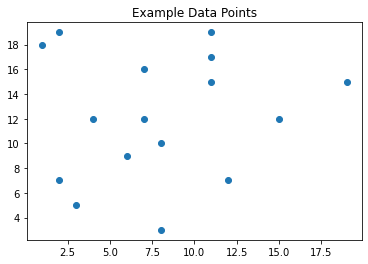

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


MIN_SIZE = 2
# Example data
np.random.seed(42)
X = np.random.randint(1, 20, size=16)
Y = np.random.randint(1, 20, size=16)
plt.scatter(X, Y)
plt.title("Example Data Points")
plt.show()

Here we initialize the clustering process by randomly selecting an initial centroid and assigning points to the nearest cluster based on Euclidean distance. The code then checks for clusters with fewer than MIN_SIZE points and marks their points as outliers. The resulting clusters and centroids exclude those with fewer than MIN_SIZE points.

In [ ]:
# Randomly choose initial centroid
initial_centroid_index = np.random.choice(range(len(X)))
initial_centroid = (X[initial_centroid_index], Y[initial_centroid_index])

# Initialize clusters and centroids
clusters = [[]]
centroids = [initial_centroid]

# Loop through data points
for i in range(len(X)):
    point = (X[i], Y[i])
    # Find the nearest centroid
    nearest_centroid = None
    min_distance = float('inf')
    for j in range(len(centroids)):
        distance = ((point[0]-centroids[j][0])**2 + (point[1]-centroids[j][1])**2)**0.5
        if distance < min_distance:
            nearest_centroid = j
            min_distance = distance
    # Assign point to nearest cluster or create new cluster
    if min_distance < 4:
        clusters[nearest_centroid].append(point)
    else:
        clusters.append([point])
        centroids.append(point)
    # Update centroids to mean of their clusters
    for j in range(len(centroids)):
        points_in_cluster = clusters[j]
        if len(points_in_cluster) > 0:
            centroid_x = sum([p[0] for p in points_in_cluster]) / len(points_in_cluster)
            centroid_y = sum([p[1] for p in points_in_cluster]) / len(points_in_cluster)
            centroids[j] = (centroid_x, centroid_y)

outliers = []  # initialize an empty list to store the outliers
cluster_indices_to_remove = []  # initialize an empty list to store the indices of clusters to remove

# Loop through each cluster and check if it has less than MIN_SIZE points
for i in range(len(clusters)):
    if len(clusters[i]) < MIN_SIZE:
        # If a cluster has less than MIN_SIZE points, add its points to the outliers list and mark it for removal
        cluster_indices_to_remove.append(i)
        outliers += clusters[i]

# Convert outliers to a numpy array for ease of use later
outliers = np.array(outliers)

# Remove the clusters that were marked for removal using a list comprehension
clusters = [item for i, item in enumerate(clusters) if i not in cluster_indices_to_remove]
centroids =[item for i, item in enumerate(centroids) if i not in cluster_indices_to_remove]

**Visualizing Clusters and Outliers**

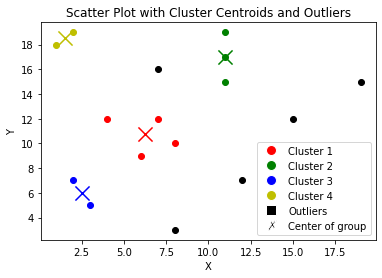

In [ ]:
from matplotlib.lines import Line2D
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'w']
for i in range(len(clusters)):
    color = colors[i % len(colors)]
    for point in clusters[i]:       
        plt.scatter(point[0], point[1], c=color)
    plt.scatter(centroids[i][0], centroids[i][1], c=color, marker='x', s=200)

# Plot the outliers in black
plt.scatter(outliers[:, 0], outliers[:, 1], c='k')

# Add a legend for the clusters and outliers
legend_elements = []
for i in range(len(clusters)):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Cluster '+str(i+1), markerfacecolor=colors[i % len(colors)], markersize=10))
if len(outliers) > 0:
    legend_elements.append(Line2D([0], [0], marker='s', color='w', label='Outliers', markerfacecolor='k', markersize=10))
legend_elements.append(Line2D([0], [0], marker='$\u2717$', color='w', label='Center of group', markerfacecolor='k', markersize=10))
plt.legend(handles=legend_elements)
plt.title("Scatter Plot with Cluster Centroids and Outliers")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Run the algorithm on our data
Running the algorithm is a crucial step in achieving our goal, and the time it takes to complete will depend on the size of the dataset. For larger datasets with more than 10,000 sentences, this process may take a few minutes to finish.


In [ ]:
clusters_indexes, centeroids = generate_clusters_indexes_and_centeroids(data,int(config["min_cluster_size"]),threshold=0.65)

Iteration #1 finished, 32 clusters
Iteration #2 finished, 33 clusters
Iteration #3 finished, 34 clusters
Iteration #4 finished, 34 clusters
Iteration #5 finished, 34 clusters
Iteration #6 finished, 34 clusters
Iteration #7 finished, 34 clusters
Iteration #8 finished, 34 clusters
Iteration #9 finished, 34 clusters
Iteration #10 finished, 34 clusters


# Step 3: Convert cluster indexes to real clusters

In [ ]:
real_clusters = cluster_indexes_to_real_clusters(clusters_indexes,data,config['data_file'])


 # Step 4: Filter clusters based on minimum size and obtain outlier sentences

In [ ]:
filtered_clusters,outliers_list = filter_clusters(real_clusters,int(config["min_cluster_size"]))

Outliers:  488  real clusters:  34


# Step 5: Generate representative sentences for each cluster

In [ ]:
clusters_sentences,clusters_center_similarity = get_sentence_to_centeroid_similarity(filtered_clusters,centeroids)
max_reps = generate_representative_sentences(filtered_clusters,clusters_center_similarity,clusters_sentences,int(config['num_of_representatives']))


**Present a selection of representative sentences from few of the respective clusters for display and analysis.**

In [ ]:
import pandas as pd

# Sample data
table_data = {'Cluster': [], 'Representative': [], 'Cluster Size': [], 'Samples': []}

for i in random.sample(range(len(max_reps)), 3):
    cluster_size = len(clusters_sentences[i])
    samples = [clusters_sentences[i][j] for j in random.sample(range(cluster_size), 3)]
    table_data['Cluster'].append(i)
    table_data['Representative'].append('\n'.join(max_reps[i]))
    table_data['Cluster Size'].append(cluster_size)
    table_data['Samples'].append('\n'.join(samples))

# Create DataFrame
df = pd.DataFrame(table_data)

# Apply formatting to DataFrame
df = (df.style
      .set_properties(subset=['Representative'], **{'white-space': 'pre-line'})
      .set_properties(subset=['Samples'], **{'white-space': 'pre-line'})
      .set_caption('Representative Sentences and Sample Sentences for Clusters'))

# Display DataFrame
display(df)


,Cluster,Representative,Cluster Size,Samples
0,8,how do i treat coronavirus? what's the best way to prevent coronavirus? how can i prevent coronavirus,30,what is the best way to prevent coronavirus what is effective prevention against covid? what cleaning methods kill the coronavirus?
1,24,how does covid spread how does covid spread? how does covid-19 spread to others,30,how does covid-19 spread to others how does the virus spread how to prevent the spread of the virus
2,11,what's the difference between flu and coronavirus? how's the flu different from coronavirus? flu vs coronavirus,33,sars vs corona virus? how's the flu different from coronavirus? flu vs. covid-19


# Step 6: Generate cluster names using topics and ngrams

In [ ]:
clusters_topics, topic_labels = generate_clusters_topics(clusters_sentences)
clusters_ngrams = generate_clusters_ngrams(filtered_clusters, clusters_sentences)
clusters_topics_dictionaries = create_clusters_topics_dictionaries(clusters_topics)
clusters_names = generate_clusters_names(clusters_topics_dictionaries, clusters_ngrams)

**Now that we have compiled all relevant information regarding our clusters, it is appropriate to showcase our results to evaluate the efficacy of our analysis.**

In [ ]:
# Select 3 random clusters to display
random_clusters = random.sample(range(len(clusters_names)), 3)

# Create a dataframe to hold the information for the selected clusters
display_df = pd.DataFrame(columns=['Cluster #', 'Cluster Name', 'Cluster Size', 'Representative', 'Samples'])

# Iterate over the selected clusters and add their information to the dataframe
for i in random_clusters:
    rep = "\n".join(max_reps[i])
    samples = "\n".join(random.sample(clusters_sentences[i], 3))
    display_df = display_df.append({'Cluster #': i, 'Cluster Name': clusters_names[i], 
                                    'Cluster Size': len(clusters_sentences[i]), 'Representative': rep, 
                                    'Samples': samples}, ignore_index=True)

# Display the dataframe with pretty formatting
display_df = (display_df.style
      .set_properties(subset=['Cluster Name'], **{'white-space': 'pre-line'})
      .set_properties(subset=['Representative'], **{'white-space': 'pre-line'})
      .set_properties(subset=['Samples'], **{'white-space': 'pre-line'})
      .set_caption('Representative Sentences and Sample Sentences for Clusters'))
display(display_df)


,Cluster #,Cluster Name,Cluster Size,Representative,Samples
0,32,safe to go,17,can i go to the grocery store can i go to the grocery store? can i go to grocery stores,are grocery stores still open can i go to the grocery store am i allowed to go to the grocery store?
1,28,where can,30,is there a test kit for coronavirus is there a test kit for the coronavirus? is there a test for coronavirus,is there test kit for coronavirus where can i get tested for coronavirus testing spots for coronavirus?
2,17,how long,19,how long does the coronavirus last? how long does the corona virus last? incubation period of coronavirus?,incubation period of coronavirus? how long does the virus last? incubation period of coronavirus?


# Step 7: Create output dictionaries for each cluster

In [ ]:
output_dictionaries = create_output_dictionaries_list(filtered_clusters, clusters_names, max_reps)
outliers_sentences = convert_outliers_to_sentence_list(outliers_list)

# Step 8: Convert output dictionaries and outlier sentences to JSON and save to file

In [ ]:
convert_result_list_to_json_file(output_dictionaries,outliers_sentences,config['output_file'])

**The preceding steps signify the completion of our analysis. At this juncture, it is imperative to perform an evaluation of our results and compare them against the actual outcomes.**

In [ ]:
evaluate_clustering(config['example_solution_file'], config['output_file'])

rand score: 0.9309255079006772
adjusted rand score: 0.6989974657789322
